Loading 2020 census tracts...
  Number of tracts: 85187

=== YEAR 2021 ===
  Using TCC raster for 2021: /mnt/sda-21.8/bdevoe/greenspace/tcc/2021/nlcd_tcc_CONUS_2021_v2023-5_wgs84/nlcd_tcc_conus_wgs84_v2023-5_20210101_20211231.tif (priority=0)
  Detected TCC raster CRS: PROJCS["Albers_Conical_Equal_Area",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
  Reprojecting tracts to TCC raster CRS (once)...
  Running zonal_stats for all tracts...
  Filled column 'tcc_2021' with 83509 non-

/tmp/ipykernel_100809/1182075294.py:151: RuntimeWarning: Mean of empty slice
  tcc_mean_3yr = np.nanmean(tcc_values, axis=1)
/tmp/ipykernel_100809/1182075294.py:152: RuntimeWarning: All-NaN slice encountered
  tcc_min_3yr  = np.nanmin(tcc_values, axis=1)
/tmp/ipykernel_100809/1182075294.py:153: RuntimeWarning: All-NaN slice encountered
  tcc_max_3yr  = np.nanmax(tcc_values, axis=1)
/home/bdevoe/.local/lib/python3.9/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_100809/1182075294.py:170: UserWarning: Geometry column does not contain geometry.
  tracts_for_csv["geometry"] = tracts_for_csv.geometry.to_wkt()


  -> /mnt/sda-21.8/bdevoe/greenspace/processed/tract_tcc_nlcd_2021_2023_summary.csv

Plotting quick TCC 2023 map for sanity check...
  -> /mnt/sda-21.8/bdevoe/greenspace/figures/tract_tcc_2023_mean_map.png


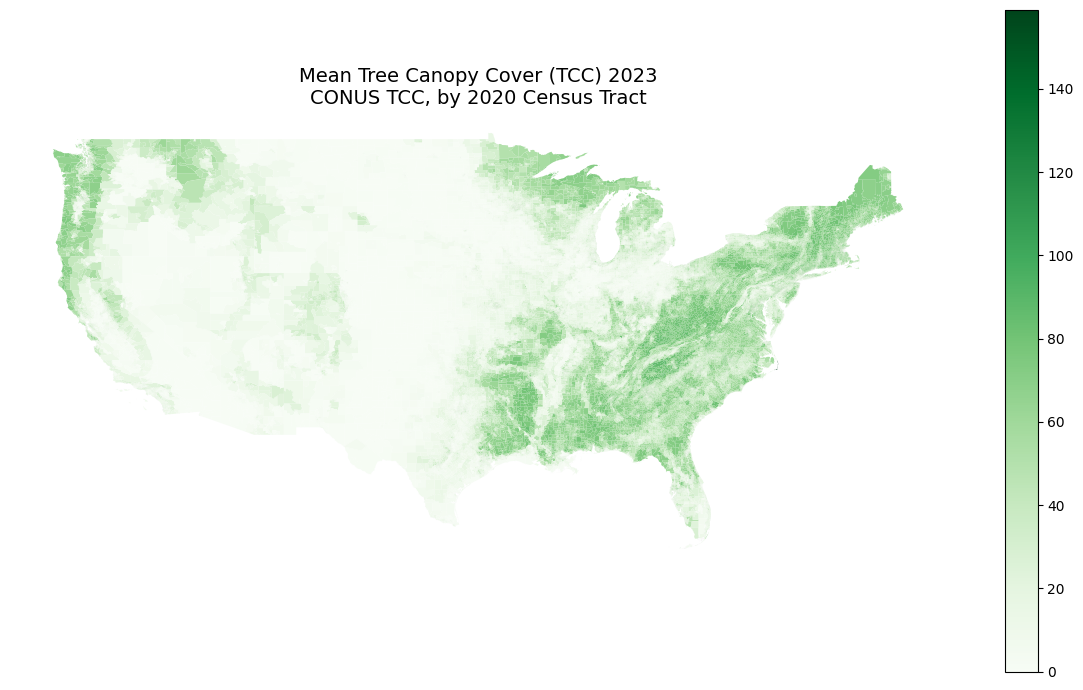


Done.


In [1]:
# ------------------------------------------------------------
# Tree Canopy Cover (TCC) aggregation to 2020 census tracts
# Years: 2021, 2022, 2023 (CONUS TCC, WGS84)
# Output: tract_tcc_nlcd_2021_2023_summary.csv
#
# Uses NLCD TCC if valid; otherwise falls back to science TCC.
# ------------------------------------------------------------

from pathlib import Path
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
from rasterstats import zonal_stats
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# Paths & config
# ------------------------------------------------------------
REPO_ROOT     = Path("/mnt/sda-21.8/bdevoe/greenspace")
RESOURCES_DIR = REPO_ROOT / "resources"
PROCESSED_DIR = REPO_ROOT / "processed"
FIGURES_DIR   = REPO_ROOT / "figures"
TCC_ROOT      = REPO_ROOT / "tcc"

TRACTS_SHP = RESOURCES_DIR / "tracts" / "cb_2020_us_tract_500k.shp"

TCC_YEARS  = [2021, 2022, 2023]
YEAR_START = min(TCC_YEARS)
YEAR_END   = max(TCC_YEARS)

# ------------------------------------------------------------
# Helper: find a valid TCC raster for a given year
# ------------------------------------------------------------
def find_tcc_raster(year: int) -> Path:
    """
    Search tcc/<year>/ for *.tif inside subdirs like:
      nlcd_tcc_CONUS_YYYY_v2023-5_wgs84
      science_tcc_CONUS_YYYY_v2023-5_wgs84

    Rules:
      1) Ignore 0-byte files.
      2) Prefer NLCD files over science files.
      3) Prefer larger files (should be the main CONUS raster).
      4) Try opening with rasterio; skip if it fails.
    """
    year_dir = TCC_ROOT / str(year)
    if not year_dir.exists():
        raise FileNotFoundError(f"TCC year directory not found: {year_dir}")

    candidates = []
    for sub in year_dir.iterdir():
        if not sub.is_dir():
            continue
        if "tcc_CONUS" not in sub.name:
            continue
        for tif in sub.glob("*.tif"):
            if tif.stat().st_size == 0:
                # definitely broken / placeholder
                continue
            name_lower = tif.name.lower()
            # priority: 0 = nlcd, 1 = science, 2 = anything else
            if "nlcd_tcc" in name_lower:
                pri = 0
            elif "science_tcc" in name_lower:
                pri = 1
            else:
                pri = 2
            size = tif.stat().st_size
            candidates.append((pri, -size, tif))

    if not candidates:
        raise FileNotFoundError(f"No non-empty TCC .tif candidates found in {year_dir}")

    # sort by priority, then by descending size
    candidates.sort()

    last_error = None
    for pri, neg_size, tif in candidates:
        try:
            # test opening; close immediately
            with rasterio.open(tif) as src:
                _ = src.count  # force some metadata read
            print(f"  Using TCC raster for {year}: {tif} (priority={pri})")
            return tif
        except Exception as e:
            print(f"  Warning: failed to open {tif} ({e}), trying next candidate...")
            last_error = e

    raise RuntimeError(
        f"Failed to open any TCC raster for {year} in {year_dir}. "
        f"Last error: {last_error}"
    )

# ------------------------------------------------------------
# Load tracts
# ------------------------------------------------------------
print("Loading 2020 census tracts...")
tracts = gpd.read_file(TRACTS_SHP)
tracts = tracts[["GEOID", "geometry"]].copy()
tracts = tracts.reset_index(drop=True)
print(f"  Number of tracts: {len(tracts)}")

tracts_proj = None  # reprojected copy once we know raster CRS

# ------------------------------------------------------------
# Per-year TCC aggregation
# ------------------------------------------------------------
for year in TCC_YEARS:
    print(f"\n=== YEAR {year} ===")

    tcc_tif = find_tcc_raster(year)

    with rasterio.open(tcc_tif) as src:
        if tracts_proj is None:
            print(f"  Detected TCC raster CRS: {src.crs}")
            print("  Reprojecting tracts to TCC raster CRS (once)...")
            tracts_proj = tracts.to_crs(src.crs)

        band = src.read(1)
        affine = src.transform
        nodata = src.nodata

        print("  Running zonal_stats for all tracts...")
        zs = zonal_stats(
            vectors=tracts_proj["geometry"],
            raster=band,
            affine=affine,
            nodata=nodata,
            stats=["mean"],
            all_touched=False,
        )

    means = np.array(
        [z["mean"] if (z["mean"] is not None) else np.nan for z in zs],
        dtype=float,
    )

    col_name = f"tcc_{year}"
    tracts[col_name] = means
    print(f"  Filled column '{col_name}' with {np.isfinite(means).sum()} non-NaN values.")

# ------------------------------------------------------------
# Multi-year summaries (2021–2023)
# ------------------------------------------------------------
print("\nComputing multi-year TCC summaries (2021–2023)...")

year_cols = [f"tcc_{y}" for y in TCC_YEARS]
tcc_values = tracts[year_cols].to_numpy(dtype=float)

tcc_mean_3yr = np.nanmean(tcc_values, axis=1)
tcc_min_3yr  = np.nanmin(tcc_values, axis=1)
tcc_max_3yr  = np.nanmax(tcc_values, axis=1)
tcc_std_3yr  = np.nanstd(tcc_values, axis=1)

tracts[f"tcc_mean_{YEAR_START}_{YEAR_END}"] = tcc_mean_3yr
tracts[f"tcc_min_{YEAR_START}_{YEAR_END}"]  = tcc_min_3yr
tracts[f"tcc_max_{YEAR_START}_{YEAR_END}"]  = tcc_max_3yr
tracts[f"tcc_std_{YEAR_START}_{YEAR_END}"]  = tcc_std_3yr

print("  Done computing 3-year summaries.")

# ------------------------------------------------------------
# Save CSV for merging with NDVI/EVI
# ------------------------------------------------------------
print("\nSaving TCC summary CSV...")

tracts_for_csv = tracts.copy()
tracts_for_csv["geoid"] = tracts_for_csv["GEOID"]
tracts_for_csv["geometry"] = tracts_for_csv.geometry.to_wkt()

csv_cols = (
    ["geoid", "GEOID", "geometry"]
    + year_cols
    + [
        f"tcc_mean_{YEAR_START}_{YEAR_END}",
        f"tcc_min_{YEAR_START}_{YEAR_END}",
        f"tcc_max_{YEAR_START}_{YEAR_END}",
        f"tcc_std_{YEAR_START}_{YEAR_END}",
    ]
)

csv_path = PROCESSED_DIR / f"tract_tcc_nlcd_{YEAR_START}_{YEAR_END}_summary.csv"
tracts_for_csv[csv_cols].to_csv(csv_path, index=False)
print(f"  -> {csv_path}")

# ------------------------------------------------------------
# Quick sanity map: TCC 2023 mean
# ------------------------------------------------------------
try:
    print("\nPlotting quick TCC 2023 map for sanity check...")
    fig, ax = plt.subplots(figsize=(12, 7))
    tracts.plot(
        column="tcc_2023",
        ax=ax,
        legend=True,
        cmap="Greens",
        linewidth=0,
    )
    ax.set_title(
        "Mean Tree Canopy Cover (TCC) 2023\nCONUS TCC, by 2020 Census Tract",
        fontsize=14,
    )
    ax.set_axis_off()
    plt.tight_layout()
    fig_path = FIGURES_DIR / "tract_tcc_2023_mean_map.png"
    plt.savefig(fig_path, dpi=300, bbox_inches="tight")
    print(f"  -> {fig_path}")
    plt.show()
except Exception as e:
    print(f"  Warning: plotting failed (non-fatal): {e}")

print("\nDone.")


In [2]:
# ------------------------------------------------------------
# TCC 2023 + 3-yr summary vs NDVI/EVI
#   - Uses existing TCC CSV from previous zonal_stats run
#   - Computes/ensures 2023 and 2021–2023 mean TCC
#   - Merges with NDVI & EVI tract summaries
#   - Prints correlation matrix of the means (no saving)
# ------------------------------------------------------------

import numpy as np
import pandas as pd
from pathlib import Path

# ------------------------------------------------------------
# Paths (adjust only if your filenames differ)
# ------------------------------------------------------------
REPO_ROOT   = Path("/mnt/sda-21.8/bdevoe/greenspace")
TCC_SUMMARY = REPO_ROOT / "processed" / "tract_tcc_nlcd_2021_2023_summary.csv"
NDVI_SUMMARY = REPO_ROOT / "processed" / "tract_ndvi_summer_2021_2025_summary.csv"
EVI_SUMMARY  = REPO_ROOT / "processed" / "tract_evi_summer_2021_2025_summary.csv"

# ------------------------------------------------------------
# 1) Load TCC summary and make sure 2023 + 3-yr mean exist
# ------------------------------------------------------------
print(f"Loading TCC summary: {TCC_SUMMARY}")
tcc = pd.read_csv(TCC_SUMMARY)
print("  TCC columns:", list(tcc.columns))

# Find GEOID column
def get_geoid_col(df):
    for col in ["GEOID", "geoid", "GEOID20"]:
        if col in df.columns:
            return col
    raise ValueError("Could not find GEOID/geoid column.")

tcc_geoid = get_geoid_col(tcc)
tcc = tcc.rename(columns={tcc_geoid: "GEOID"})
tcc["GEOID"] = tcc["GEOID"].astype(str)

# Identify per-year TCC columns
year_cols = {}
for year in [2021, 2022, 2023]:
    col = f"tcc_{year}"
    if col not in tcc.columns:
        raise ValueError(f"Expected column '{col}' in TCC file but did not find it.")
    year_cols[year] = col

# Ensure 3-year mean exists; recompute if needed
mean_col = "tcc_mean_2021_2023"
if mean_col not in tcc.columns:
    print("  3-year mean column not found; computing from 2021–2023...")
    vals = tcc[[year_cols[2021], year_cols[2022], year_cols[2023]]].to_numpy(dtype="float64")
    tcc[mean_col] = np.nanmean(vals, axis=1)
else:
    print(f"  Found existing '{mean_col}' column.")

# We’ll keep just GEOID, TCC 2023, and 3-yr mean
tcc_small = tcc[["GEOID", "tcc_2023", mean_col]].copy()

# ------------------------------------------------------------
# 2) Load NDVI and EVI summaries
# ------------------------------------------------------------
print(f"\nLoading NDVI summary: {NDVI_SUMMARY}")
ndvi = pd.read_csv(NDVI_SUMMARY)
print("  NDVI columns:", list(ndvi.columns))

print(f"\nLoading EVI summary:  {EVI_SUMMARY}")
evi = pd.read_csv(EVI_SUMMARY)
print("  EVI columns:", list(evi.columns))

ndvi_geoid = get_geoid_col(ndvi)
evi_geoid  = get_geoid_col(evi)

# Adjust these if your mean columns are named differently
ndvi_mean_col = "mean_ndvi"
evi_mean_col  = "mean_evi"

if ndvi_mean_col not in ndvi.columns:
    raise ValueError(f"Expected '{ndvi_mean_col}' in NDVI file, found {ndvi.columns}.")
if evi_mean_col not in evi.columns:
    raise ValueError(f"Expected '{evi_mean_col}' in EVI file, found {evi.columns}.")

ndvi_small = ndvi[[ndvi_geoid, ndvi_mean_col]].rename(
    columns={ndvi_geoid: "GEOID", ndvi_mean_col: "mean_ndvi"}
)
ndvi_small["GEOID"] = ndvi_small["GEOID"].astype(str)

evi_small = evi[[evi_geoid, evi_mean_col]].rename(
    columns={evi_geoid: "GEOID", evi_mean_col: "mean_evi"}
)
evi_small["GEOID"] = evi_small["GEOID"].astype(str)

# ------------------------------------------------------------
# 3) Merge TCC + NDVI + EVI
# ------------------------------------------------------------
merged = (
    tcc_small
    .merge(ndvi_small, on="GEOID", how="left")
    .merge(evi_small,  on="GEOID", how="left")
)

print(f"\nMerged rows (TCC + NDVI + EVI): {len(merged)}")

# ------------------------------------------------------------
# 4) Correlation matrix of the means
# ------------------------------------------------------------
cols_for_corr = ["tcc_2023", "tcc_mean_2021_2023", "mean_ndvi", "mean_evi"]
corr = merged[cols_for_corr].corr(method="pearson")

print("\n========================================")
print("Correlation matrix of mean indicators")
print("  TCC 2023, TCC 2021–2023 mean, NDVI mean, EVI mean")
print("========================================\n")
print(corr.round(4))
print("\nDone.")


Loading TCC summary: /mnt/sda-21.8/bdevoe/greenspace/processed/tract_tcc_nlcd_2021_2023_summary.csv
  TCC columns: ['geoid', 'GEOID', 'geometry', 'tcc_2021', 'tcc_2022', 'tcc_2023', 'tcc_mean_2021_2023', 'tcc_min_2021_2023', 'tcc_max_2021_2023', 'tcc_std_2021_2023']
  Found existing 'tcc_mean_2021_2023' column.

Loading NDVI summary: /mnt/sda-21.8/bdevoe/greenspace/processed/tract_ndvi_summer_2021_2025_summary.csv
  NDVI columns: ['geoid', 'GEOID', 'geometry', 'mean_ndvi', 'median_ndvi', 'min_ndvi', 'max_ndvi', 'std_ndvi', 'q10_ndvi', 'q25_ndvi', 'q75_ndvi', 'q90_ndvi', 'pct_ndvi_ge_050', 'pct_ndvi_ge_075', 'pct_ndvi_ge_090']

Loading EVI summary:  /mnt/sda-21.8/bdevoe/greenspace/processed/tract_evi_summer_2021_2025_summary.csv
  EVI columns: ['geoid', 'GEOID', 'geometry', 'mean_evi', 'median_evi', 'min_evi', 'max_evi', 'std_evi', 'q10_evi', 'q25_evi', 'q75_evi', 'q90_evi', 'pct_evi_ge_050', 'pct_evi_ge_075', 'pct_evi_ge_090']

Merged rows (TCC + NDVI + EVI): 85187

Correlation matrix 

In [3]:
# ------------------------------------------------------------
# purpose: Build master tract-level greenspace input table
#          and print summary statistics (NO index yet)
# author:  brian devoe
# ------------------------------------------------------------

import pandas as pd
import numpy as np

# ------------------------------------------------------------
# 0) Paths
# ------------------------------------------------------------
BASE = "/mnt/sda-21.8/bdevoe/greenspace/processed"

NDVI_FILE = f"{BASE}/tract_ndvi_summer_2021_2025_summary.csv"
EVI_FILE  = f"{BASE}/tract_evi_summer_2021_2025_summary.csv"
TCC_FILE  = f"{BASE}/tract_tcc_nlcd_2021_2023_summary.csv"

# ------------------------------------------------------------
# 1) Load data
# ------------------------------------------------------------
print("Loading datasets...")

ndvi = pd.read_csv(NDVI_FILE)
evi  = pd.read_csv(EVI_FILE)
tcc  = pd.read_csv(TCC_FILE)

print(f"  NDVI rows: {len(ndvi)}")
print(f"  EVI rows:  {len(evi)}")
print(f"  TCC rows:  {len(tcc)}")

# ------------------------------------------------------------
# 2) Keep only needed columns
# ------------------------------------------------------------
ndvi_keep = ndvi[[
    "GEOID",
    "mean_ndvi"
]]

evi_keep = evi[[
    "GEOID",
    "mean_evi"
]]

tcc_keep = tcc[[
    "GEOID",
    "tcc_2023",
    "tcc_mean_2021_2023"
]]

# ------------------------------------------------------------
# 3) Merge to master table
# ------------------------------------------------------------
master = (
    ndvi_keep
    .merge(evi_keep, on="GEOID", how="left")
    .merge(tcc_keep, on="GEOID", how="left")
)

print(f"\nMaster tract table rows: {len(master)}")

# ------------------------------------------------------------
# 4) Summary statistics
# ------------------------------------------------------------
vars_to_summarize = [
    "mean_ndvi",
    "mean_evi",
    "tcc_2023",
    "tcc_mean_2021_2023"
]

print("\n========================================")
print("SUMMARY STATISTICS (TRACT LEVEL)")
print("========================================\n")

for v in vars_to_summarize:
    s = master[v]
    print(f"--- {v} ---")
    print(f"  N non-missing: {s.notna().sum():,}")
    print(f"  Mean:          {s.mean():.4f}")
    print(f"  Std dev:       {s.std():.4f}")
    print(f"  Min:           {s.min():.4f}")
    print(f"  10th pct:      {s.quantile(0.10):.4f}")
    print(f"  25th pct:      {s.quantile(0.25):.4f}")
    print(f"  Median:        {s.quantile(0.50):.4f}")
    print(f"  75th pct:      {s.quantile(0.75):.4f}")
    print(f"  90th pct:      {s.quantile(0.90):.4f}")
    print(f"  Max:           {s.max():.4f}")
    print()

# ------------------------------------------------------------
# 5) Correlation matrix (means only)
# ------------------------------------------------------------
print("\n========================================")
print("CORRELATION MATRIX (MEANS ONLY)")
print("========================================\n")

corr = master[vars_to_summarize].corr()
print(corr.round(3))

print("\nDone.")


Loading datasets...
  NDVI rows: 85187
  EVI rows:  85187
  TCC rows:  85187

Master tract table rows: 85187

SUMMARY STATISTICS (TRACT LEVEL)

--- mean_ndvi ---
  N non-missing: 83,509
  Mean:          0.5377
  Std dev:       0.1996
  Min:           -0.4744
  10th pct:      0.2386
  25th pct:      0.3895
  Median:        0.5648
  75th pct:      0.7067
  90th pct:      0.7816
  Max:           0.8969

--- mean_evi ---
  N non-missing: 83,509
  Mean:          0.3721
  Std dev:       0.1458
  Min:           -0.1297
  10th pct:      0.1633
  25th pct:      0.2599
  Median:        0.3801
  75th pct:      0.4875
  90th pct:      0.5635
  Max:           0.7370

--- tcc_2023 ---
  N non-missing: 83,509
  Mean:          22.4591
  Std dev:       19.3497
  Min:           0.0000
  10th pct:      1.6377
  25th pct:      6.4022
  Median:        16.9102
  75th pct:      35.2006
  90th pct:      52.0219
  Max:           158.9200

--- tcc_mean_2021_2023 ---
  N non-missing: 83,509
  Mean:          23.6